In this notebook we do data preparation. This entails to augmenting the data by performing 10 random elastic deformations on each of the 30 images and masks producing a total of 300 training images and masks.

We start by installing the necessary packages

In [1]:
import os
from pathlib import PurePath
from torch_snippets import torch, Dataset, stems, read, randint, write, plt
import numpy as np
from scipy import interpolate
import matplotlib
from tqdm import notebook
import cv2 as cv2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

2021-09-01 11:52:59.311 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-09-01 11:53:00.754 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


x(::-1) reverses the top level numpy array (horizontal mirroring of image). Vertical mirroring is done by flip(...). Rotation by 180 degrees is achieved by combining vertical and horizontal mirroring in any order.

In [2]:
def mirror_extrapolation(x):
    vert_mir=np.flip(x,1)
    rot180=np.flip(x[::-1],1)
    top_bottom=np.hstack((rot180,x[::-1],rot180))
    return np.vstack((top_bottom,np.hstack((vert_mir,x,vert_mir)),top_bottom))

And now for the random elastic deformations. The function generateRandomElastic2D(...) generas a 572*572 array of random displacements following the outline of the paper. The implementation is slow, so we should apply it only once during the data preparation stage and not during training.

In [3]:
def generate_random_elastic_1d():
    displacements=np.random.normal(loc=0.0, scale=10.0, size=(4,4))
    x = np.array([0.0, 1.0, 2.0, 3.0])
    y = np.array([0.0, 1.0, 2.0, 3.0])
    f = interpolate.interp2d(x, y, displacements, kind="cubic")
    grid_displacements = np.empty([572, 572], dtype=int)
   
    for x in range(572):
        for y in range(572):
            grid_displacements[x][y] = int(f(3.0 * x / 571.0,3.0 * y / 571.0))
        
    return grid_displacements

def generate_random_elastic_2d():
    grid_displacements_x = generate_random_elastic_1d()
    grid_displacements_y = generate_random_elastic_1d()
    grid_displacements=np.array([grid_displacements_x,grid_displacements_y])
    grid_displacements = grid_displacements.swapaxes(0,2)
    return grid_displacements

Vi now execute the elastic deformations on our image base. The method being to use the displacements in a backward manner in the middle (572*572) size portion of our mirror extrapolated image. For each pixel in this middle region we calculate what pixel in the larger image should be copied to it.

Given a grid displacement array and an image we now calculate the deformed image

In [4]:
def elastic_deformation(img, displacement):
    extrapolated = mirror_extrapolation(img)
    deformed = np.empty_like(img)

    for x in range(572):
        for y in range(572):
            deformed[x][y]=extrapolated[x + 572 + displacement[x][y][0]][y + 572 + displacement[x][y][1]]

    return deformed

The generation of elastic deformations was the heavy duty job above, so we would like to create a bunch of them and save to disk, to be reused later. The method of generating a new batch of 10 displacements will be to just delete the deformations folder.

In [5]:
NOF_DEFORMATIONS = 10
if not os.path.exists(r"isbi-datasets-master\deformations"):
    os.mkdir(r"isbi-datasets-master\deformations")
    GridDisplacements = np.empty([NOF_DEFORMATIONS, 572, 572, 2], dtype=int)
    with open(r"isbi-datasets-master\deformations\deformations.npy", "wb") as f:
        for x in range(NOF_DEFORMATIONS):
            print(x)
            GridDisplacements[x] = generate_random_elastic_2d()
            np.save(f, GridDisplacements)

In [6]:
if os.path.exists(r"isbi-datasets-master\deformations"):
    with open(r"isbi-datasets-master\deformations\deformations.npy", "rb") as f:
        GridDisplacements = np.load(f)

    print(GridDisplacements.shape)

(10, 572, 572, 2)


Now that we have 10 displacements we apply each to our 30 images and create a folder for that purpose. We need a Dataset instance to iterate the images

In [7]:
class SegData(Dataset):
    def __init__(self, aug=None):
        self.items = stems("isbi-datasets-master/data/images")
        self.aug = aug
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        name = PurePath(self.items[ix]).name[-2:]
        image = read(f"isbi-datasets-master/data/images/train-volume{name}.jpg",1)
        image = cv2.resize(image, (572,572))
        mask = read(f"isbi-datasets-master/data/labels/train-labels{name}.jpg")
        mask = cv2.resize(mask, (572,572))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def get_stem(self,ix): return PurePath(self.items[ix]).name[-2:]

In [ ]:
ds = SegData()

In [ ]:
if not os.path.exists(r"isbi-datasets-master\data\deformed_images"):
    os.mkdir(r"isbi-datasets-master\data\deformed_images")
    for j in notebook.tnrange(len(GridDisplacements), desc="deformed_images"):
        for i in range(len(ds)):
            Deformed = elastic_deformation(ds[i][0],GridDisplacements[j])
            write(Deformed,f"isbi-datasets-master/data/deformed_images/train-volume{ds.getStem(i)}_{j:02d}.jpg")

In [9]:
if not os.path.exists(r"isbi-datasets-master\data\deformed_labels"):
    os.mkdir(r"isbi-datasets-master\data\deformed_labels")
    for j in notebook.tnrange(len(GridDisplacements), desc='deformed_labels'):
        for i in range(len(ds)):
            Deformed = elastic_deformation(ds[i][1],GridDisplacements[j])
            write(Deformed,f"isbi-datasets-master/data/deformed_labels/train-labels{ds.getStem(i)}_{j:02d}.jpg")

Now that we have deformed our labels, we would like to convert these gray scale images into binary images, where 0 means backround and 1 means a cell border pixel.

We start out with a Dataset, to easily iterate through the deformed labels

In [10]:
class deformed_labels(Dataset):
    def __init__(self):
        self.items = stems("isbi-datasets-master/data/deformed_labels")
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        name = PurePath(self.items[ix]).name[-5:]
        mask = read(f"isbi-datasets-master/data/deformed_labels/train-labels{name}.jpg")
        return mask
    def choose(self): return self[randint(len(self))]
    def get_stem(self,ix): return PurePath(self.items[ix]).name[-5:]

In [11]:
labels = deformed_labels()

2021-09-01 11:53:56.240 | INFO     | torch_snippets.loader:stems:66 - 300 files found at isbi-datasets-master/data/deformed_labels


Now that we have our data, we create a new folder for our binary images and convert from gray scale to binary using bimodal histogram thresholding.

In [12]:
if not os.path.exists(r"isbi-datasets-master\data\deformed_binary_labels"):
    os.mkdir(r"isbi-datasets-master\data\deformed_binary_labels")
    for i in notebook.tnrange(len(labels), desc='deformed_binary_labels'):
        mask = labels[i]
        ret,th = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding
        name = labels.get_stem(i)
        write(th,f"isbi-datasets-master/data/deformed_binary_labels/train-labels{name}.png")

Proof of concept of above method

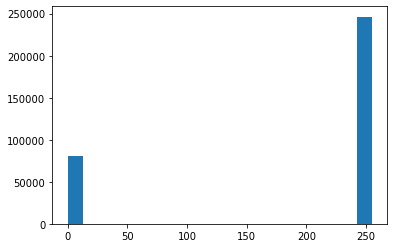

In [13]:
mask = labels[30]
ret,th = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding
matplotlib.pyplot.hist(th.flatten(), bins="auto")
matplotlib.pyplot.show()


Given the binary files we see that they are somewhat imbalanced and we compute the weight maps described in the paper.

In [14]:
if os.path.exists(r"isbi-datasets-master\data\deformed_binary_labels") and not os.path.exists(r"isbi-datasets-master\data\wc.npy"):
    wc0=np.zeros((572, 572))
    wc1=np.full((572, 572), NOF_DEFORMATIONS * 30)
    for i in notebook.tnrange(len(labels), desc="deformed_binary_labels"):
        name = labels.get_stem(i)
        mask = read(f"isbi-datasets-master/data/deformed_binary_labels/train-labels{name}.png")
        mask = mask/255
        wc0 = wc0 + mask

    wc1 = wc1 - wc0
    wc0 = wc0/(NOF_DEFORMATIONS * 30)
    wc1 = wc1/(NOF_DEFORMATIONS * 30)

    wc0 = np.expand_dims(wc0, axis=2)
    wc1 = np.expand_dims(wc1, axis=2)
    wc  = np.concatenate((wc0, wc1), axis=2)
    #print(wc)

    with open(r"isbi-datasets-master\data\wc.npy", "wb") as f:
        np.save(f, wc)

In [15]:
with open(r"isbi-datasets-master\data\wc.npy", "rb") as f:
    wc = np.load(f)

And now for the two maps d1 and d2 have to be computed per image. The thing is quite complicated, but can be implemented using the following steps:

a) Calculate the connected foreground components of the binary images
b) For each pair of components calculate the min distance between them
c) For each component find the nearest and second nearest component
d) For each foreground pixel calculate the distance to the nearest and second nearest component

The computations of connected components is risky as there might be "holes" in the borders. This could be fixed by the mentioned morphological operations, but a much simpler approech for the ISBI2012 dataset is to simply calculate the distance of each pixel to the nearest neighbour (d1) and ignoring the second nearest neighbour (d2). This can then be achieved by the distance transform, which we calculate for each mask and save in a folder.

In order to simplify both the later calculations of the loss function and its debugging friendliness we simply precompute w(x) for each training image and save as a tensor


In [17]:
if not os.path.exists(r"isbi-datasets-master\data\wx"):
    W0  = 10
    SIGMA = 5
    os.mkdir(r"isbi-datasets-master\data\wx")
    for i in notebook.tnrange(len(labels), desc='wx'):
        name = labels.get_stem(i)
        mask = read(f"isbi-datasets-master/data/deformed_binary_labels/train-labels{name}.png")
        d = torch.from_numpy(cv2.distanceTransform(mask,cv2.DIST_L2,3))
        wx = W0 * torch.exp(-torch.mul(d, d) / (SIGMA * SIGMA))
        with open("isbi-datasets-master/data/wx/wx" + name + ".npy", "wb") as f:
            np.save(f, wx)

In [19]:
if not os.path.exists(r"isbi-datasets-master\data\distance_transforms"):
    os.mkdir(r"isbi-datasets-master\data\distance_transforms")
    for i in notebook.tnrange(len(labels), desc='distance_transforms'):
        name = labels.get_stem(i)
        mask = read(f"isbi-datasets-master/data/deformed_binary_labels/train-labels{name}.png")
        dist_transform = cv2.distanceTransform(mask,cv2.DIST_L2,3)
        with open("isbi-datasets-master/data/distance_transforms/distance-transform" + name + ".npy", "wb") as f:
            np.save(f, dist_transform)

Lets check that the distance transforms stored look ok. We know that there are 71455 zero pixels in the mask image below (00_00). This is consistent with the distance transform histogram showing that amount of pixels having zero distance to a border. The zero pixels are the borders

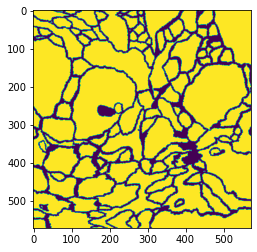

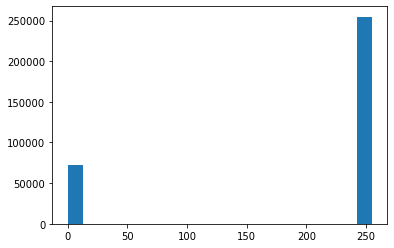

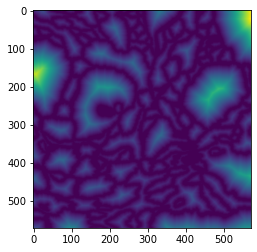

NUmber of zero pixels: 72470


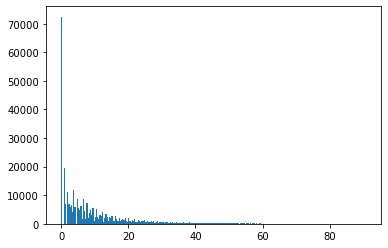

In [20]:
with open("isbi-datasets-master/data/distance_transforms/distance-transform00_00.npy", "rb") as f:
    dist_transform = np.load(f)

mask = read("isbi-datasets-master/data/deformed_binary_labels/train-labels00_00.png")

plt.imshow(mask)
plt.show()

matplotlib.pyplot.hist(mask.flatten(), bins="auto")
matplotlib.pyplot.show()

plt.imshow(dist_transform)
plt.show()

print("NUmber of zero pixels: " + str(mask[np.where(mask == 0)].size))
matplotlib.pyplot.hist(dist_transform.flatten(), bins='auto')
matplotlib.pyplot.show()